In [1]:
library(gam)
library(mvgam)           # Fit, interrogate and forecast DGAMs
library(dplyr)           # Tidy and flexible data manipulation
library(marginaleffects) # Compute conditional and marginal effects
library(ggplot2)         # Flexible plotting
library(patchwork)       # Combining ggplot objects

Loading required package: splines

Loading required package: foreach

Loaded gam 1.22-5


Welcome to mvgam. Please cite as: Clark, NJ, and Wells, K. 2022. Dynamic Generalized Additive Models (DGAMs) for forecasting discrete ecological time series. Methods in Ecology and Evolution, 2022, https://doi.org/10.1111/2041-210X.13974


Attaching package: ‘mvgam’


The following object is masked from ‘package:gam’:

    s



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
theme_set(theme_classic(base_size = 12, base_family = 'serif') +
            theme(axis.line.x.bottom = element_line(colour = "black",
                                                    size = 1),
                  axis.line.y.left = element_line(colour = "black",
                                                  size = 1)))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


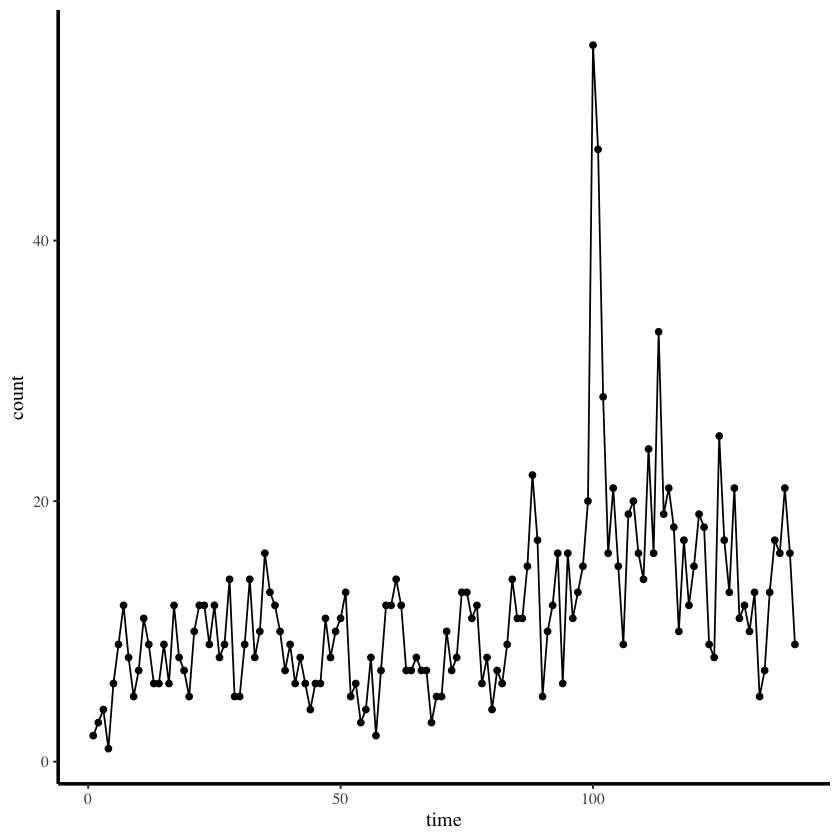

In [3]:
# Download the campy data from the tscount package
load(url('https://github.com/cran/tscount/raw/master/data/campy.RData'))

# Put data into a data.frame and visualize
dat <- data.frame(count = as.vector(campy)) %>%
  dplyr::mutate(time = 1:dplyr::n())
ggplot(dat, aes(time, count)) + 
  geom_point() +
  geom_line()

In [9]:
dat

count,time
<dbl>,<int>
2,1
3,2
4,3
1,4
6,5
9,6
12,7
8,8
5,9


In [4]:
# Replicating mgcv::gam.check() but without the plots
small_check = function(model){
  cat("Basis dimension (k) checking results. Low p-value (k-index < 1) may\n") 
  cat("indicate that k is too low, especially if edf is close to k\'.\n\n")
  printCoefmat(mgcv::k.check(model), digits = 3)
}

# Call marginaleffects::plot_predictions to inspect model fits
plot_fcs = function(model, n_ahead = 0){
  p <- plot_predictions(model, 
                   condition = list(time = 1:(max(dat$time) + n_ahead)),
                   type = 'response',
                   points = 0.5)
  
  if(n_ahead > 0){
    p <- p + 
      geom_vline(xintercept = max(dat$time), 
                 linetype = 'dashed')
  }
  p
}

plot_links = function(model, n_ahead = 0){
  p <- plot_predictions(model, 
                   condition = list(time = 1:(max(dat$time) + n_ahead)),
                   type = 'link') +
    ylab('linear predictor')
  
    if(n_ahead > 0){
    p <- p + 
      geom_vline(xintercept = max(dat$time), 
                 linetype = 'dashed')
  }
  p
}

In [5]:
mod1 <- gam(count ~ s(time, k = 6),
            data = dat,
            family = poisson(),
            method = 'REML')
small_check(mod1)

ERROR: Error in model.frame.default(formula = count ~ s(time, k = 6), data = dat, : invalid type (list) for variable 's(time, k = 6)'


In [7]:
mod5 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 23,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = dat,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Warning message in mvgam(count ~ 1, trend_formula = ~gp(time, c = 5/4, k = 23, scale = FALSE), :
“cmdstanr library not found. Defaulting to rstan”
Compiling Stan program using rstan



Start sampling

Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


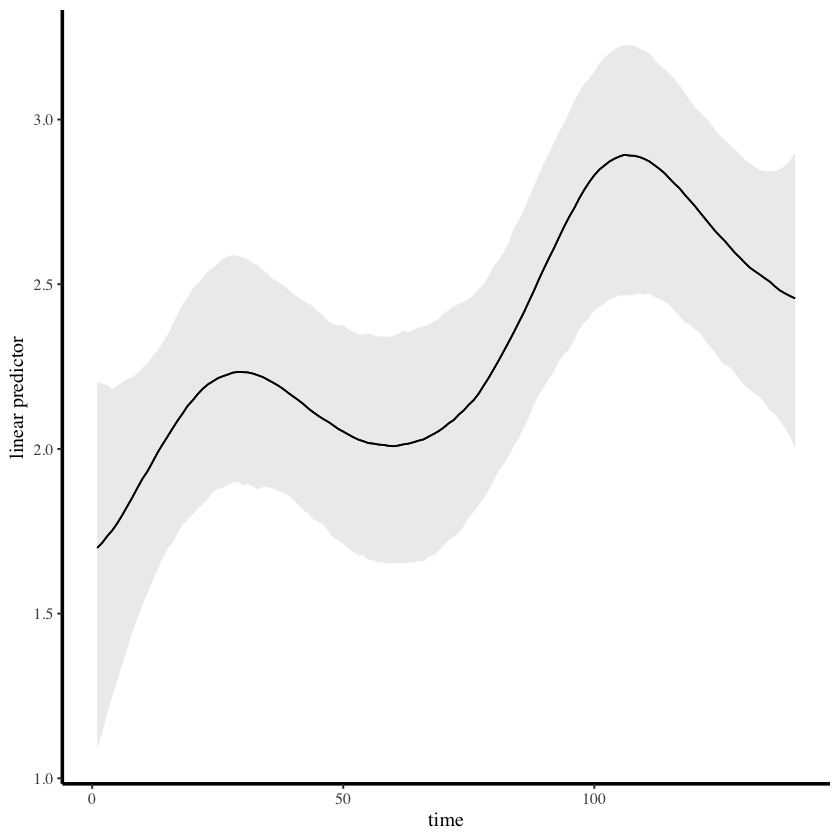

In [11]:
plot_links(mod5)

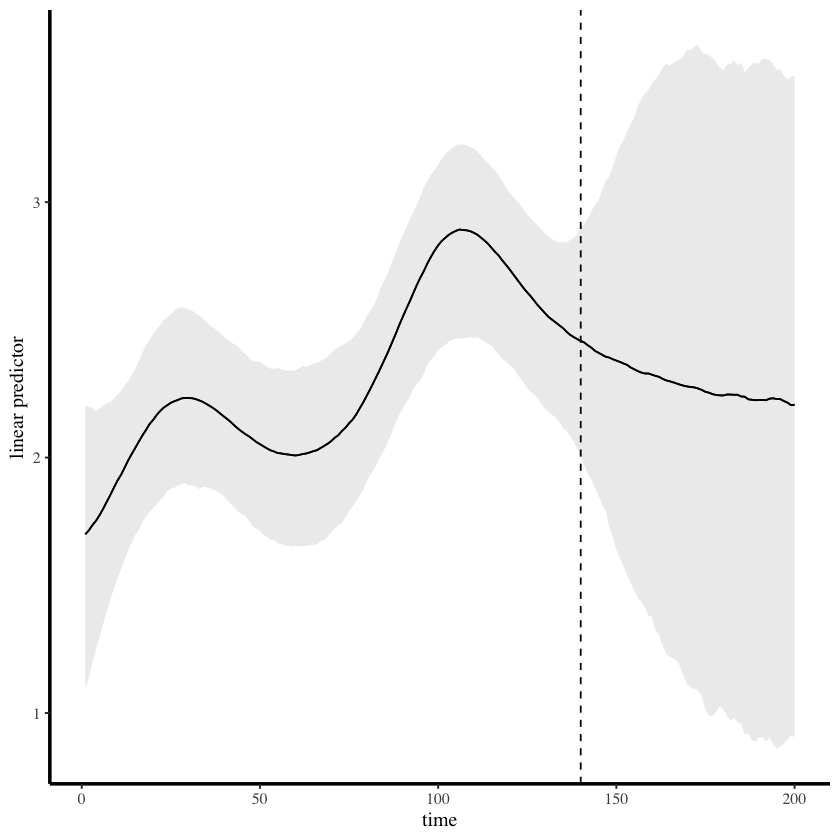

In [13]:
plot_links(mod5, n_ahead = 60)

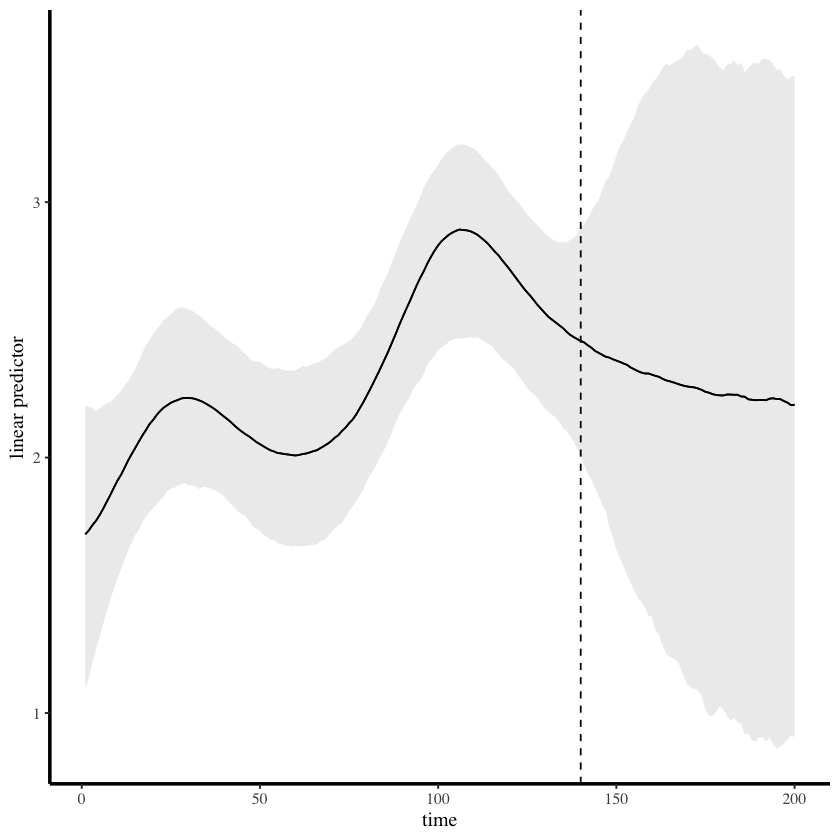

In [15]:
plot_links(mod5, n_ahead = 60)

In [18]:
mod6 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 50,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = dat,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Warning message in mvgam(count ~ 1, trend_formula = ~gp(time, c = 5/4, k = 50, scale = FALSE), :
“cmdstanr library not found. Defaulting to rstan”
Compiling Stan program using rstan



Start sampling

Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


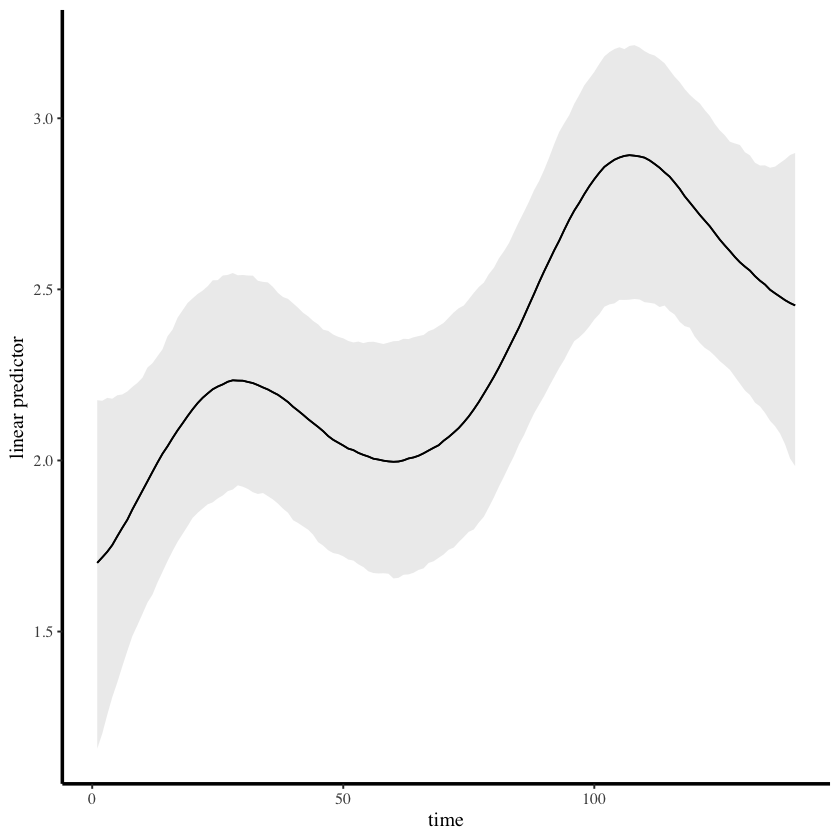

In [21]:
plot_links(mod6)

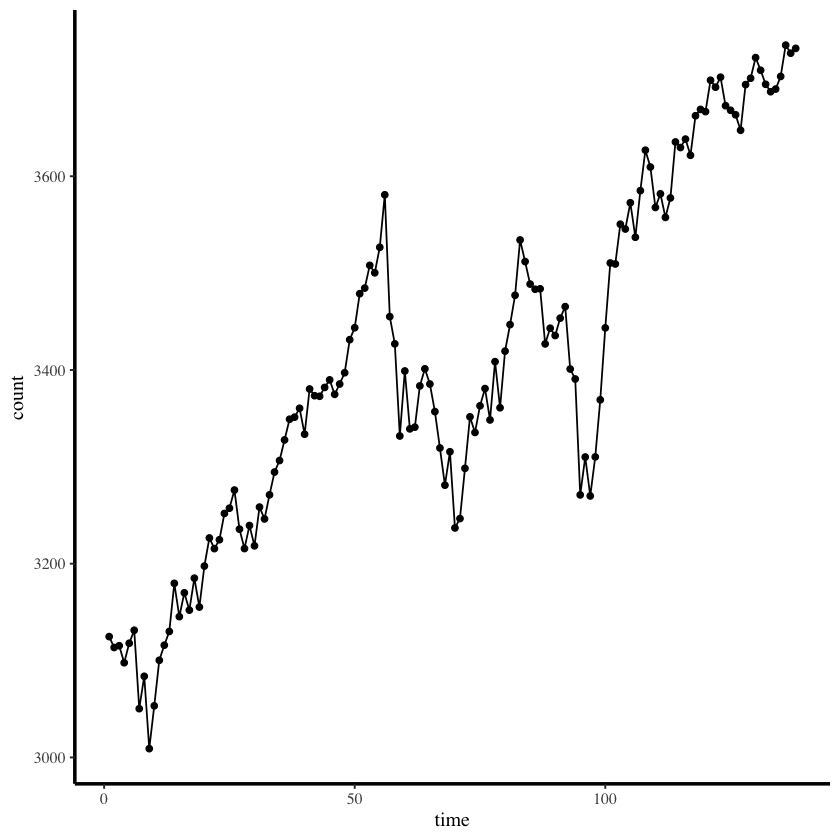

In [44]:
dat2 <- read.csv("sp500_train_s.csv")
ggplot(dat2, aes(time, count)) + 
  geom_point() +
  geom_line()

In [68]:
head(dat2)

,count,time
,<dbl>,<int>
1,3124.74,1
2,3113.49,2
3,3115.34,3
4,3097.74,4
5,3117.86,5
6,3131.29,6


In [66]:
mod7 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 2, k = 23,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = dat2,
            family = poisson())

ERROR: Error in if (abs(old.score - score) > score.scale * conv.tol) {: missing value where TRUE/FALSE needed


In [60]:
plot_links(mod7)

ERROR: Error: object 'mod7' not found
